# TensorFlow script mode training and serving
###  Modified From: 
#### Sagemaker Python SDK Examples: tensorflow_script_mode_training_and_serving.ipynb
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb

Following modifications were made:  
1. Incorporated scripts for local mode hosting  
2. Added Train and Test Channels  
3. Visualize results (confusion matrix and reports)  
4. Added steps to deploy using model artifacts stored in S3  
5. Iris model training

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script.


# Set up the environment

Let's start by setting up the environment:

### Local Mode Execution - requires docker compose configured
#### The below setup script is from AWS SageMaker Python SDK Examples : tf-eager-sm-scriptmode.ipynb

!/bin/bash ./setup.sh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [3]:
print(role)
print(region)

arn:aws:iam::223817798831:role/service-role/AmazonSageMaker-ExecutionRole-20200708T194212
us-east-1


## Training Data

In [4]:
#column_list_file = 'iris_train_column_list.txt'
data_folder_name='data'
train_filename = 'spa.txt'
non_breaking_en = 'nonbreaking_prefix.en'
non_breaking_es = 'nonbreaking_prefix.es'
trainedmodel_path = 'trained_model'
model_info_file = 'model_info.pth'
input_vocab_file = 'in_vocab.pkl'
output_vocab_file = 'out_vocab.pkl'

train_file = os.path.abspath(os.path.join(data_folder_name, train_filename))
non_breaking_en_file = os.path.abspath(os.path.join(data_folder_name, non_breaking_en))
non_breaking_es_file = os.path.abspath(os.path.join(data_folder_name, non_breaking_es))
trainedmodel_file = os.path.abspath(os.path.join(trainedmodel_path, non_breaking_es))

In [5]:
# Specify your bucket name
bucket_name = 'edumunozsala-ml-sagemaker'

training_folder = r'transformer-nmt/train'
output_folder = r'transformer-nmt'
ckpt_folder = r'transformer-nmt/ckpt'

training_data_uri = r's3://' + bucket_name + r'/' + training_folder
output_data_uri = r's3://' + bucket_name + r'/' + output_folder
ckpt_data_uri = r's3://' + bucket_name + r'/' + ckpt_folder

In [6]:
training_data_uri,output_data_uri,ckpt_data_uri

('s3://edumunozsala-ml-sagemaker/transformer-nmt/train',
 's3://edumunozsala-ml-sagemaker/transformer-nmt',
 's3://edumunozsala-ml-sagemaker/transformer-nmt/ckpt')

In [7]:
sagemaker_session.upload_data(train_file,
                              bucket=bucket_name, 
                              key_prefix=training_folder)

sagemaker_session.upload_data(non_breaking_en_file,
                              bucket=bucket_name, 
                              key_prefix=training_folder)

sagemaker_session.upload_data(non_breaking_es_file,
                              bucket=bucket_name, 
                              key_prefix=training_folder)

's3://edumunozsala-ml-sagemaker/transformer-nmt/train/nonbreaking_prefix.es'

sagemaker_session.upload_data(test_file, 
                              bucket=bucket_name, 
                              key_prefix=test_folder)

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [8]:
!pygmentize 'train/train.py'

import argparse
import json
import sys
#import sagemaker_containers

import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf

# To install tensorflow_datasets
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])

# Install the library tensorflow_datasets
install('tensorflow_datasets')

from utils import preprocess_text_nonbreaking, subword_tokenize
#from utils_train import loss_function, CustomSchedule

from model import Transformer

INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
#NUM_SAMPLES = 80000 #40000
#MAX_VOCAB_SIZE = 2**14

#BATCH_SIZE = 64  # Batch size for training.
#EPOCHS = 10  # Number of epochs to train for.
#MAX_LENGTH = 15

def get_train_data(training_dir, nonbreaking_in, nonbreaking_out, train_file, nsamples):
    print("Get the train data loader.")
    # Load the nonbreaking files
    with open(os.path.join(training_dir, n

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 



In [9]:
from sagemaker.tensorflow import TensorFlow

You can also initiate an estimator to train with TensorFlow 2.1 script. The only things that you will need to change are the script name and ``framewotk_version``

In [10]:
#instance_type='ml.m5.xlarge'
instance_type='ml.m4.4xlarge'
#instance_type='local'

In [11]:
estimator = TensorFlow(entry_point='train.py',
                       source_dir="train",
                       role=role,
                       train_instance_count=1,
                       train_instance_type=instance_type,
                       framework_version='2.1.0',
                       py_version='py3',
                       output_path=output_data_uri,
                       base_job_name='tf-transformer',
                       script_mode= True,
                       #checkpoint_local_path = 'ckpt',
                       checkpoint_s3_uri = ckpt_data_uri,
                       hyperparameters={
                        'epochs': 1,
                        'nsamples': 5000,
                        'train_file': 'spa.txt',
                        'non_breaking_in': 'nonbreaking_prefix.en',
                        'non_breaking_out': 'nonbreaking_prefix.es'
                       })
                       #distributions={'parameter_server': {'enabled': False}})

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

Calling fit to train a model with TensorFlow 2.1 scroipt.

In [12]:
#estimator.fit({'training':training_data_uri,'testing':testing_data_uri})
estimator.fit({'training':training_data_uri})

2020-11-07 17:49:03 Starting - Starting the training job...
2020-11-07 17:49:05 Starting - Launching requested ML instances......
2020-11-07 17:50:15 Starting - Preparing the instances for training......
2020-11-07 17:51:04 Downloading - Downloading input data...
2020-11-07 17:51:55 Training - Training image download completed. Training in progress..2020-11-07 17:52:00,541 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-07 17:52:00,547 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-07 17:52:01,905 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-07 17:52:01,923 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-07 17:52:01,940 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-07 17:52:01,953 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters":

Input vocab:  1976
Output vocab:  3865
Creating the checkpoint ...
Training the model ....
Starting epoch 1
Epoch 1 Batch 0 Loss 2.7229 Accuracy 0.0000
Saving checkpoint for epoch 1 in /opt/ml/checkpoints/ckpt-1
Saving the model parameters
Saving the dictionaries ....
2020-11-07 17:52:48,200 sagemaker_tensorflow_container.training WARNING  Your model will NOT be servable with SageMaker TensorFlow Serving container. The model artifact was not saved in the TensorFlow SavedModel directory structure:
https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory
2020-11-07 17:52:48,200 sagemaker-containers INFO     Reporting training SUCCESS

2020-11-07 17:52:59 Uploading - Uploading generated training model
2020-11-07 17:52:59 Completed - Training job completed
Training seconds: 115
Billable seconds: 115


### Attach a previous training job

In [9]:
# Set the training job you want to attach to the estimator object
my_training_job_name = 'tf-transformer-2020-11-07-16-35-42-885'
# Attach the estimator to the selected training job
estimator = TensorFlow.attach(my_training_job_name)


2020-11-07 16:40:41 Starting - Preparing the instances for training
2020-11-07 16:40:41 Downloading - Downloading input data
2020-11-07 16:40:41 Training - Training image download completed. Training in progress.
2020-11-07 16:40:41 Uploading - Uploading generated training model
2020-11-07 16:40:41 Completed - Training job completed


In [13]:
estimator.latest_training_job.job_name

'tf-transformer-2020-11-07-17-49-03-516'

In [17]:
print(estimator.model_data)
print(bucket_name)

s3://edumunozsala-ml-sagemaker/transformer-nmt/tf-transformer-2020-11-07-17-49-03-516/output/model.tar.gz
edumunozsala-ml-sagemaker


## DownLoad the trained model

In [12]:
import boto3

s3 = boto3.resource('s3')
inference_results_bucket = s3.Bucket(bucket_name)
 
inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

NameError: name 's3_output_key' is not defined

In [18]:
s3_model_path='transformer-nmt/tf-transformer-2020-11-07-17-49-03-516/output/model.tar.gz'

In [19]:
sagemaker_session.download_data(trainedmodel_path,bucket_name,s3_model_path)

Next, extract the information out from the model.tar.gz file return by the training job in SageMaker:

In [20]:
!tar -zxvf $trainedmodel_path/model.tar.gz

transformer.index
out_vocab.pkl
model_info.pth
in_vocab.pkl
checkpoint
transformer.data-00000-of-00001


### Import the tensorflow model and load the model

In [21]:
from train.model import Transformer
import pickle

We need to restore the parameters of the model we have saved in order to build an instance of the Transformer model

In [22]:
# Read the parameters from a dictionary
#model_info_path = os.path.join(model_dir, 'model_info.pth')
with open(model_info_file, 'rb') as f:
    model_info = pickle.load(f)
print('Model parameters',model_info)

Model parameters {'vocab_size_enc': 1976, 'vocab_size_dec': 3865, 'sos_token_input': [1974], 'eos_token_input': [1975], 'sos_token_output': [3863], 'eos_token_output': [3864], 'n_layers': 4, 'd_model': 64, 'ffn_dim': 128, 'n_heads': 8, 'drop_rate': 0.1}


In [23]:
#Create an instance of the Transforer model and load the saved model to th
transformer = Transformer(vocab_size_enc=model_info['vocab_size_enc'],
                          vocab_size_dec=model_info['vocab_size_dec'],
                          d_model=model_info['d_model'],
                          n_layers=model_info['n_layers'],
                          FFN_units=model_info['ffn_dim'],
                          n_heads=model_info['n_heads'],
                          dropout_rate=model_info['drop_rate'])

In [24]:
#Load thr saved model
transformer.load_weights('transformer')

## Make some predictions

In [17]:
# Install the library necessary to tokenize the sentences
!pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.1.0-py3-none-any.whl (3.6 MB)
Processing /home/ec2-user/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1/promise-2.3-py3-none-any.whl
  Using cached tensorflow_metadata-0.25.0-py3-none-any.whl (44 kB)
  Using cached dataclasses-0.7-py3-none-any.whl (18 kB)
  Using cached importlib_resources-3.3.0-py2.py3-none-any.whl (26 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached dill-0.3.3-py2.py3-none-any.whl (81 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
ERROR: tensorflow-metadata 0.25.0 has requirement absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [29]:
%load_ext autoreload
%autoreload 2

from serve.predict import translate
import tensorflow_datasets as tfds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the input and output tokenizer or vocabularis used in the training. We need them to encode and decode the sentences

In [26]:
# Read the parameters from a dictionary
#model_info_path = os.path.join(model_dir, 'model_info.pth')
with open(input_vocab_file, 'rb') as f:
    tokenizer_inputs = pickle.load(f)

with open(output_vocab_file, 'rb') as f:
    tokenizer_outputs = pickle.load(f)


In [31]:
#Show some translations
sentence = "you should pay for it."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(transformer,sentence,tokenizer_inputs, tokenizer_outputs,15,model_info['sos_token_input'],
                               model_info['eos_token_input'],model_info['sos_token_output'],
                               model_info['eos_token_output'])
print("Output sentence: {}".format(predicted_sentence))

Input sentence: you should pay for it.
Output sentence: 


# Deploy the trained model to an endpoint

The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code]() document explains how SageMaker runs inference containers.

Deployed the trained TensorFlow 2.1 model to an endpoint.

In [18]:
predictor = estimator.deploy(initial_instance_count=1, instance_type=instance_type)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------------------------------*

UnexpectedStatusException: Error hosting endpoint tf-transformer-2020-11-06-16-29-07-384: Failed. Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

# Invoke the endpoint

Let's download the training data and use that as input for inference.

Examine the prediction result from the TensorFlow 2.1 model.

In [16]:
df = pd.read_csv(test_file, names=columns)

algo-1-5daal_1  | 2020/03/28 21:14:44 [info] 11#11: *1 client 172.18.0.1 closed keepalive connection


In [17]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [18]:
X_test = df.iloc[:,1:].values
print(X_test[:5])

[[5.8 2.7 4.1 1. ]
 [4.8 3.4 1.6 0.2]
 [6.  2.2 4.  1. ]
 [6.4 3.1 5.5 1.8]
 [6.7 2.5 5.8 1.8]]


In [19]:
result = predictor.predict(X_test)

algo-1-5daal_1  | 172.18.0.1 - - [28/Mar/2020:21:14:44 +0000] "POST /invocations HTTP/1.1" 200 2039 "-" "-"


In [20]:
result =  result['predictions']

In [21]:
result[:5]

[[0.00026031278, 0.990563631, 0.00917605218],
 [0.999760091, 0.000239968373, 3.97464422e-10],
 [0.000185193509, 0.974752605, 0.0250621513],
 [9.90088935e-08, 0.241644651, 0.758355319],
 [1.86230598e-09, 0.0252015758, 0.974798381]]

In [22]:
df['predicted_class'] = np.argmax(result,axis=1)

In [23]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width,predicted_class
0,1,5.8,2.7,4.1,1.0,1
1,0,4.8,3.4,1.6,0.2,0
2,1,6.0,2.2,4.0,1.0,1
3,2,6.4,3.1,5.5,1.8,2
4,2,6.7,2.5,5.8,1.8,2


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [25]:
# Encode Class Labels to integers
# Labeled Classes
labels=[0,1,2]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [26]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['encoded_class'],
                              df['predicted_class'],labels=labels)

In [28]:
cnf_matrix

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  0, 18]])

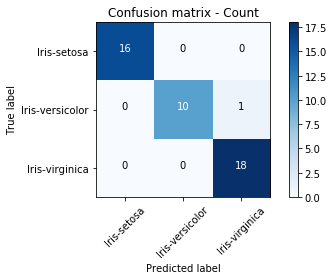

In [29]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

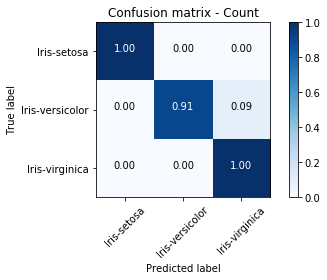

In [30]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)

In [31]:
print(classification_report(
    df['encoded_class'],
    df['predicted_class'],
    labels=labels,
    target_names=classes))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      0.91      0.95        11
 Iris-virginica       0.95      1.00      0.97        18

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



# Delete the endpoint

Let's delete the endpoint we just created to prevent incurring any extra costs.

Delete the TensorFlow 2.1 endpoint as well.

In [32]:
estimator.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


# Deploy model using artifacts
https://sagemaker.readthedocs.io/en/stable/using_tf.html#deploy-to-a-sagemaker-endpoint

In [33]:
from sagemaker.tensorflow.serving import Model

In [34]:
model_data = estimator.model_data

In [35]:
model_data

's3://chandra-ml-sagemaker/iris/model/tf-iris-2020-03-28-21-14-26-369/model.tar.gz'

In [36]:
model = Model(model_data=model_data, role=role,framework_version='2.1.0')
predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

Attaching to tmp81b25ulb_algo-1-oufpd_1
algo-1-oufpd_1  | INFO:__main__:starting services
algo-1-oufpd_1  | INFO:__main__:using default model name: model
algo-1-oufpd_1  | INFO:__main__:tensorflow serving model config: 
algo-1-oufpd_1  | model_config_list: {
algo-1-oufpd_1  |   config: {
algo-1-oufpd_1  |     name: "model",
algo-1-oufpd_1  |     base_path: "/opt/ml/model",
algo-1-oufpd_1  |     model_platform: "tensorflow"
algo-1-oufpd_1  |   }
algo-1-oufpd_1  | }
algo-1-oufpd_1  | 
algo-1-oufpd_1  | 
algo-1-oufpd_1  | INFO:__main__:nginx config: 
algo-1-oufpd_1  | load_module modules/ngx_http_js_module.so;
algo-1-oufpd_1  | 
algo-1-oufpd_1  | worker_processes auto;
algo-1-oufpd_1  | daemon off;
algo-1-oufpd_1  | pid /tmp/nginx.pid;
algo-1-oufpd_1  | error_log  /dev/stderr error;
algo-1-oufpd_1  | 
algo-1-oufpd_1  | worker_rlimit_nofile 4096;
algo-1-oufpd_1  | 
algo-1-oufpd_1  | events {
algo-1-oufpd_1  |   worker_connections 2048;
algo-1-oufpd_1  | }
algo-1-oufpd_1  | 
algo-1-oufpd_1 

algo-1-oufpd_1  | 2020-03-28 21:14:57.461390: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /opt/ml/model/000000001
algo-1-oufpd_1  | 2020-03-28 21:14:57.465019: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 67894 microseconds.
algo-1-oufpd_1  | 2020-03-28 21:14:57.465400: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /opt/ml/model/000000001/assets.extra/tf_serving_warmup_requests
algo-1-oufpd_1  | 2020-03-28 21:14:57.465666: I tensorflow_serving/util/retrier.cc:46] Retrying of Loading servable: {name: model version: 1} exhausted max_num_retries: 0
algo-1-oufpd_1  | 2020-03-28 21:14:57.465686: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: model version: 1}
algo-1-oufpd_1  | 2020-03-28 21:14:57.467364: I tensorflow_serving/model_serv

In [37]:
X_test[:5]

array([[5.8, 2.7, 4.1, 1. ],
       [4.8, 3.4, 1.6, 0.2],
       [6. , 2.2, 4. , 1. ],
       [6.4, 3.1, 5.5, 1.8],
       [6.7, 2.5, 5.8, 1.8]])

In [38]:
predictor.predict(X_test[:5])

algo-1-oufpd_1  | 172.18.0.1 - - [28/Mar/2020:21:15:01 +0000] "POST /invocations HTTP/1.1" 200 254 "-" "-"


{'predictions': [[0.00026031278, 0.990563631, 0.00917605218],
  [0.999760091, 0.000239968373, 3.97464422e-10],
  [0.000185193509, 0.974752605, 0.0250621513],
  [9.90088935e-08, 0.241644651, 0.758355319],
  [1.86230598e-09, 0.0252015758, 0.974798381]]}

In [39]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
